In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display, Image

## 0. Start Chromedriver
- **`CHROME_VERSION`**: go to your chrome settings and check your version of chrome. If your version does not match the version shown below, download the correct version of the Chromedriver from [here](https://chromedriver.chromium.org/downloads) and append the version number to the end of its name. e.g. if you have Chrome version 80, you should rename `chromedriver.exe` to `chromedriver80.exe`
  - **`Options()`**: adding `headless` and `window-size` arguments allows us to use Chromedriver without a GUI.

In [2]:
CHROME_VERSION='79'  # change this to match Chrome version on host machine

options = Options()
options.add_argument('headless')
options.add_argument('window-size=1200x600')
driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}', options=options)

---
## 1. Load upcoming Super Rugby match odds

In [3]:
driver.get( "https://www.oddsportal.com/rugby-union/world/super-rugby/")
driver.implicitly_wait(5)  # give page time to load all content

We can take a peek at what the Chromedriver sees using the `get_screenshot_as_png()` method on the driver object.

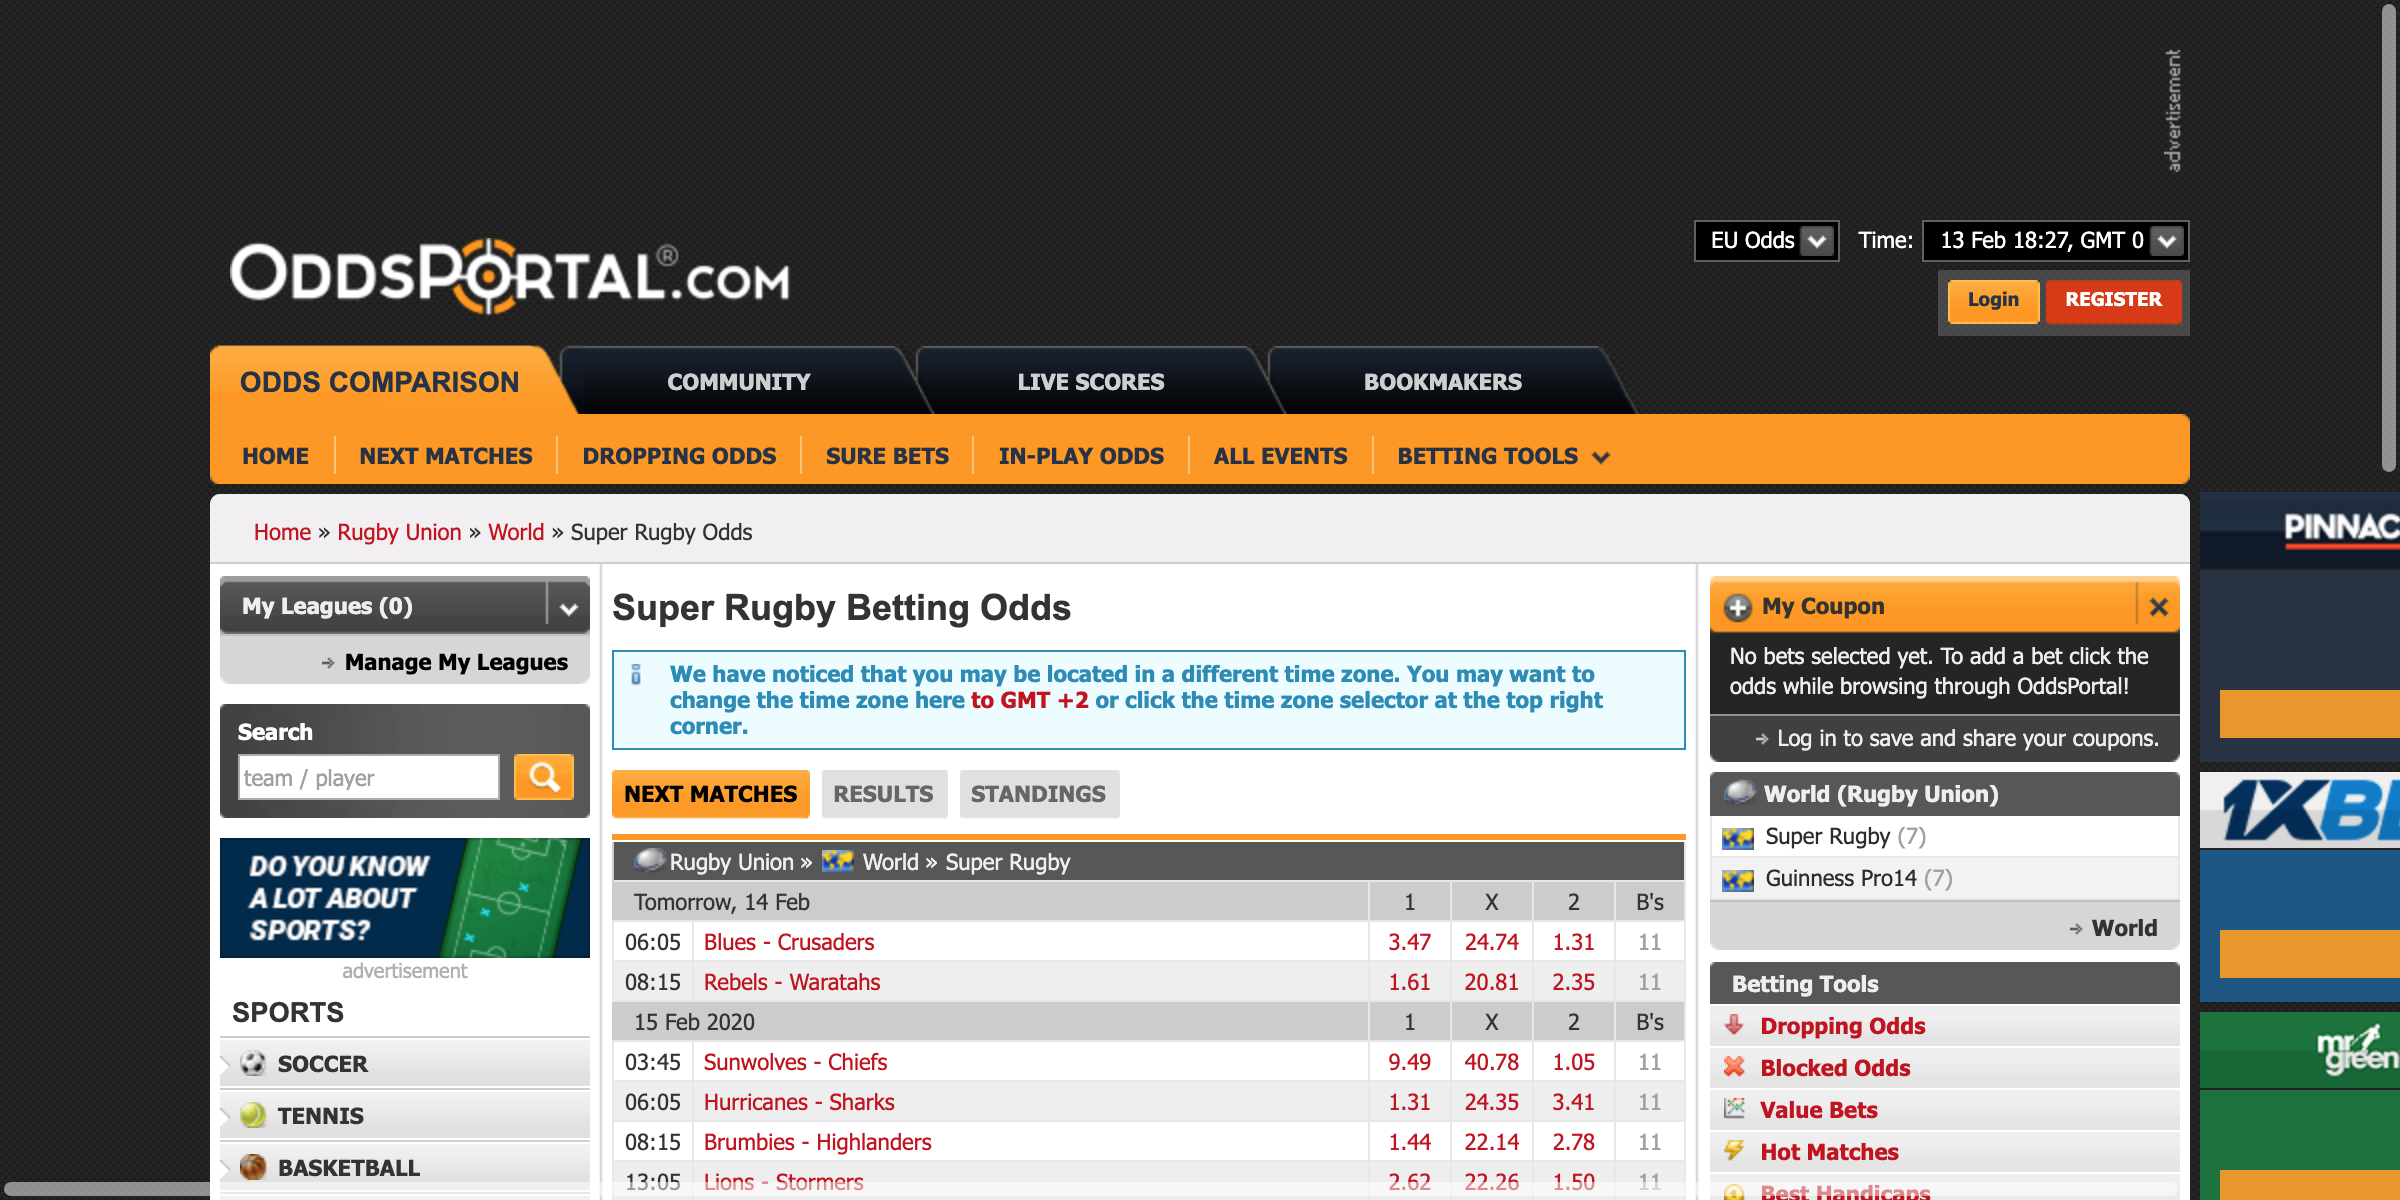

In [4]:
display(
    Image(
        driver.get_screenshot_as_png(),
        width=800,
        height=400
    )
)

In [5]:
table = driver.find_element_by_xpath('//*[@id="tournamentTable"]')

In [6]:
table.find_elements_by_xpath('//*[@id="tournamentTable"]/tbody/tr[7]')

[<selenium.webdriver.remote.webelement.WebElement (session="9fb0729b26c3888f937614850a7d65bb", element="97faa1e9-eda5-4080-ac4c-3d78a867c44e")>]

In [7]:
table.text

"Rugby Union\n»\n World\n»\nSuper Rugby\nTomorrow, 14 Feb 1 X 2 B's\n06:05 Blues - Crusaders\n3.47\n24.74\n1.31\n11\n08:15 Rebels - Waratahs\n1.61\n20.81\n2.35\n11\n15 Feb 2020 1 X 2 B's\n03:45 Sunwolves - Chiefs\n9.49\n40.78\n1.05\n11\n06:05 Hurricanes - Sharks\n1.31\n24.35\n3.41\n11\n08:15 Brumbies - Highlanders\n1.44\n22.14\n2.78\n11\n13:05 Lions - Stormers\n2.62\n22.26\n1.50\n11\n23:00 Jaguares - Reds\n1.17\n30.03\n4.88\n10"

In [8]:
table_rows = table.text.split('\n')
table_rows[:25]

['Rugby Union',
 '»',
 ' World',
 '»',
 'Super Rugby',
 "Tomorrow, 14 Feb 1 X 2 B's",
 '06:05 Blues - Crusaders',
 '3.47',
 '24.74',
 '1.31',
 '11',
 '08:15 Rebels - Waratahs',
 '1.61',
 '20.81',
 '2.35',
 '11',
 "15 Feb 2020 1 X 2 B's",
 '03:45 Sunwolves - Chiefs',
 '9.49',
 '40.78',
 '1.05',
 '11',
 '06:05 Hurricanes - Sharks',
 '1.31',
 '24.35']

In [9]:
# remove table header (first 5 lines)
table_rows = table_rows[5:]

In [10]:
# split list up by dates
date_idx = []
idx = 0
for row in table_rows:
    if "1 X 2 B's" in row:
        print(row)
        date_idx.append(idx)
    idx += 1

Tomorrow, 14 Feb 1 X 2 B's
15 Feb 2020 1 X 2 B's


In [11]:
date_idx

[0, 11]

In [12]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Score': [],
    'Away Score': [],
    'Play-off Game?': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for i in range(len(date_idx)):
    
    # extract date
    date = table_rows[date_idx[i]]
    date = date.replace(" 1 X 2 B's", '')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
        
    date = date.replace(' ', '-')
    
    first_match = date_idx[i]+1
    
    fixtures = []
    
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
        
    else:
        fixtures = table_rows[first_match:]
        
    fixtures = np.array(fixtures).reshape(-1, 5)
    date_col = np.repeat([date], fixtures.shape[0])
    fixtures = np.hstack((date_col.reshape(-1, 1), fixtures))
    
    # add each row to dictionary
    for f in fixtures:
        df['Date'].append(f[0])
        df['Home Team'].append(f[1])
        df['Away Team'].append(f[1])
        df['Home Score'].append(0)
        df['Away Score'].append(0)
        df['Play-off Game?'].append('N')
        df['Home Odds'].append(f[2])
        df['Draw Odds'].append(f[3])
        df['Away Odds'].append(f[4])
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,14-Feb-2020,06:05 Blues - Crusaders,06:05 Blues - Crusaders,0,0,N,3.47,24.74,1.31,11
1,14-Feb-2020,08:15 Rebels - Waratahs,08:15 Rebels - Waratahs,0,0,N,1.61,20.81,2.35,11
2,15-Feb-2020,03:45 Sunwolves - Chiefs,03:45 Sunwolves - Chiefs,0,0,N,9.49,40.78,1.05,11
3,15-Feb-2020,06:05 Hurricanes - Sharks,06:05 Hurricanes - Sharks,0,0,N,1.31,24.35,3.41,11
4,15-Feb-2020,08:15 Brumbies - Highlanders,08:15 Brumbies - Highlanders,0,0,N,1.44,22.14,2.78,11
5,15-Feb-2020,13:05 Lions - Stormers,13:05 Lions - Stormers,0,0,N,2.62,22.26,1.50,11
6,15-Feb-2020,23:00 Jaguares - Reds,23:00 Jaguares - Reds,0,0,N,1.17,30.03,4.88,10


In [13]:
def get_home(s):
    '''find the text between the kick-off time and the dash'''
    return re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', s).group(1).strip()

def get_away(s):
    '''find the last word of text'''
    return s.split()[-1]

print(get_home('06:05 Blues - Chiefs'))
print(get_away('06:05 Blues - Chiefs'))

Blues
Chiefs


In [14]:
df['Home Team'] = df['Home Team'].apply(get_home)
df['Away Team'] = df['Away Team'].apply(get_away)

df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,14-Feb-2020,Blues,Crusaders,0,0,N,3.47,24.74,1.31,11
1,14-Feb-2020,Rebels,Waratahs,0,0,N,1.61,20.81,2.35,11
2,15-Feb-2020,Sunwolves,Chiefs,0,0,N,9.49,40.78,1.05,11
3,15-Feb-2020,Hurricanes,Sharks,0,0,N,1.31,24.35,3.41,11
4,15-Feb-2020,Brumbies,Highlanders,0,0,N,1.44,22.14,2.78,11
5,15-Feb-2020,Lions,Stormers,0,0,N,2.62,22.26,1.50,11
6,15-Feb-2020,Jaguares,Reds,0,0,N,1.17,30.03,4.88,10


In [21]:
df.to_csv("upcoming_week.csv")